In [1]:
! which python

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/bin/python


In [2]:
import sys
sys.path.append('..')

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import optuna
import lightgbm as lgb

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

In [4]:
df1 = pd.read_excel('../dataset/train.xlsx')
df2 = pd.read_excel('../dataset/test.xlsx')

In [5]:
train = df1.copy()
test = df2.copy()

In [6]:
train.head()

,id,age,sector,edu,marital_status,field,family_rel,gender,investment_gain,investment_loss,working_hours,high_income
0,1,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,no
1,2,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,no
2,3,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,no
3,4,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,no
4,5,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,no


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               32561 non-null  int64 
 1   age              32561 non-null  int64 
 2   sector           32561 non-null  object
 3   edu              32561 non-null  object
 4   marital_status   32561 non-null  object
 5   field            32561 non-null  object
 6   family_rel       32561 non-null  object
 7   gender           32561 non-null  object
 8   investment_gain  32561 non-null  int64 
 9   investment_loss  32561 non-null  int64 
 10  working_hours    32561 non-null  int64 
 11  high_income      32561 non-null  object
dtypes: int64(5), object(7)
memory usage: 3.0+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               16281 non-null  int64 
 1   age              16281 non-null  int64 
 2   sector           16281 non-null  object
 3   edu              16281 non-null  object
 4   marital_status   16281 non-null  object
 5   field            16281 non-null  object
 6   family_rel       16281 non-null  object
 7   gender           16281 non-null  object
 8   investment_gain  16281 non-null  int64 
 9   investment_loss  16281 non-null  int64 
 10  working_hours    16281 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.4+ MB


# EDA

### Compare distribution of train and test set

In [9]:
def plot_distribution(df, column):
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True)

    # Check if the column is numeric or categorical
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f'{column} is numeric')
        # Numeric feature: Use line chart
        sns.histplot(df1[column], bins=30, kde=True, ax=axs, color='blue', label='train ' + column, alpha=0.5)

        # Add density plots for a smooth distribution
        sns.kdeplot(df1[column], ax=axs, color='blue', alpha=0.5)
    else:
        print(f'{column} is categorical')
        # Categorical feature: Use bar chart
        sns.countplot(x=column, data=df, ax=axs, color='blue', alpha=0.5)

    # Set titles and labels
    axs.set_title(f'df {column} Distribution')
    axs.set_xlabel('')
    axs.set_ylabel('Count')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def compare_dataframes(df1, df2):
    """
    This function takes two pandas DataFrames as input and draws plots to compare
    each feature's distribution of the two DataFrames using Seaborn. Bar charts are 
    used for categorical features, and line charts are used for numeric features.

    Parameters:
    df1 (pd.DataFrame): The first DataFrame.
    df2 (pd.DataFrame): The second DataFrame.
    """
    
    # Ensure that both DataFrames have the same columns
    # if not df1.columns.equals(df2.columns):
    #     raise ValueError("DataFrames must have the same columns")
    
    # Loop over each column in the DataFrames
    for column in df1.columns:
        if column not in ['high_income', 'id']:
            # Create a figure with 2 subplots
            fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

            # Check if the column is numeric or categorical
            if pd.api.types.is_numeric_dtype(df1[column]):
                print(f'{column} is numeric')
                # Numeric feature: Use line chart
                sns.histplot(df1[column], bins=30, kde=True, ax=axs[0], color='blue', label='train ' + column, alpha=0.5)
                sns.histplot(df2[column], bins=30, kde=True, ax=axs[1], color='red', label='test ' + column, alpha=0.5)

                # Add density plots for a smooth distribution
                sns.kdeplot(df1[column], ax=axs[0], color='blue', alpha=0.5)
                sns.kdeplot(df2[column], ax=axs[1], color='red', alpha=0.5)
            else:
                print(f'{column} is categorical')
                # Categorical feature: Use bar chart
                sns.countplot(x=column, data=df1, ax=axs[0], color='blue', alpha=0.5)
                sns.countplot(x=column, data=df2, ax=axs[1], color='red', alpha=0.5)

            # Set titles and labels
            axs[0].set_title(f'df1 {column} Distribution')
            axs[0].set_xlabel('')
            axs[0].set_ylabel('Count')
            axs[1].set_title(f'df2 {column} Distribution')
            axs[1].set_xlabel(column)
            axs[1].set_ylabel('Count')

            # Adjust layout and show the plots
            plt.tight_layout()
            plt.show()

# compare_dataframes(train, test)

# Pre-processing

### Strip

In [11]:
categorical_cols = train.select_dtypes(include=['object']).columns

In [12]:
for col in categorical_cols:
    if col != 'high_income':
        train[col] = train[col].str.strip()
        test[col] = test[col].str.strip()
    else:
        train[col] = train[col].str.strip()

### Binning

In [13]:
import pandas as pd

def bin_column_by_quantile(df1, column, num_bins=4, labels=None):
    """
    Divides a specified column in a DataFrame into bins based on quantiles.

    Parameters:
    df1 (pd.DataFrame): The DataFrame containing the column to be binned.
    column (str): The name of the column to be binned.
    num_bins (int): The number of quantile-based bins to create. Default is 4 (quartiles).
    labels (list): Optional list of labels for the bins. Must be the same length as num_bins.

    Returns:
    pd.DataFrame: The DataFrame with an additional column for the binned values.
    """
    
    df = df1.copy()
    if labels is not None and len(labels) != num_bins:
        raise ValueError("Length of labels must be equal to num_bins")
    
    # Create the bin edges based on quantiles
    bin_edges = pd.qcut(df[column], q=num_bins, labels=labels, retbins=True)[1]
    
    # Bin the column based on the calculated bin edges
    binned_column = pd.cut(df[column], bins=bin_edges, labels=labels, include_lowest=True)
    
    # Create a new column name for the binned values
    binned_column_name = column + '_binned'
    
    # Add the binned column to the DataFrame
    df[binned_column_name] = binned_column
    
    return df


In [14]:
# train = bin_column_by_quantile(train, 'age', num_bins=4, labels=[1, 2, 3, 4])
# test = bin_column_by_quantile(test, 'age', num_bins=4, labels=[1, 2, 3, 4])
# train.head()

In [15]:
def bin_column_by_custom_quantiles(df, column, quantiles=[0.25, 0.75], labels=None):
    """
    Divides a specified column in a DataFrame into bins based on custom quantiles.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the column to be binned.
    column (str): The name of the column to be binned.
    quantiles (list): A list of quantiles to use for binning. Default is [0.25, 0.75].
    labels (list): Optional list of labels for the bins. Must be one less than the length of quantiles + 1.

    Returns:
    pd.DataFrame: The DataFrame with an additional column for the binned values.
    """
    
    # Calculate the quantile values
    quantile_values = df[column].quantile(quantiles).tolist()
    
    # Define the bin edges
    bins = [-float('inf')] + quantile_values + [float('inf')]
    
    # If labels are not provided, create default labels
    if labels is None:
        labels = [i+1 for i in range(len(bins) - 1)]
    
    # Ensure the number of labels matches the number of bins
    if len(labels) != len(bins) - 1:
        raise ValueError("The number of labels must be one less than the number of bins")
    
    # Bin the column based on the calculated bin edges
    binned_column = pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
    
    # Create a new column name for the binned values
    binned_column_name = column + '_binned'
    
    # Add the binned column to the DataFrame
    df[binned_column_name] = binned_column
    
    return df

In [16]:
train = bin_column_by_custom_quantiles(train, 'age', quantiles=[0.25, 0.75])
test = bin_column_by_custom_quantiles(test, 'age', quantiles=[0.25, 0.75])

### Processing

##### edu

In [17]:
train['edu'].value_counts()

edu
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64

In [18]:
def convert_edu(status):
    status_stripped = str(status).strip()
    if status_stripped in ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad']:
        return 'undergrad'
    elif status_stripped in ['Some-college', 'Bachelors', 'Masters', 'Assoc-voc', 'Assoc-acdm', 'Prof-school', 'Doctorate']:
        return 'grad'

In [19]:
train['edu_new'] = train['edu'].apply(convert_edu)
test['edu_new'] = test['edu'].apply(convert_edu)

##### marital_status

In [20]:
def convert_marital_status(status):
    status_stripped = status.strip()

    if status_stripped in ['Married-civ-spouse', 'Married-spouse-absent', 'Married-AF-spouse']:
        return 'married'
    elif status_stripped in ['Never-married', 'Separated', 'Widowed']:
        return 'single'
    elif status_stripped == 'Divorced':
        return 'divorced'
    else:
        return 'unknown'

train['marital_status_new'] = train['marital_status'].apply(convert_marital_status)
test['marital_status_new'] = test['marital_status'].apply(convert_marital_status)

##### high_income

In [21]:
income_mapping = {'no': 0, 'yes': 1}
train['high_income'] = train['high_income'].map(income_mapping)

##### field

In [22]:
def fill_missing_categorical(df, column):
    df[column] = df[column].replace('?', np.nan)

    if df[column].notna().all():
        return df

    known = df[df[column].notna()]
    unknown = df[df[column].isna()]

    le = LabelEncoder()
    known[column] = le.fit_transform(known[column])
    X_known = known.drop(column, axis=1)
    y_known = known[column]

    categorical_cols = X_known.select_dtypes(include=['object']).columns

    le_cat = preprocessing.LabelEncoder()
    X_known[categorical_cols] = X_known[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    clf = RandomForestClassifier()
    clf.fit(X_known, y_known)

    X_unknown = unknown.drop(column, axis=1)

    X_unknown[categorical_cols] = X_unknown[categorical_cols].apply(lambda col: le_cat.fit_transform(col.astype(str)))

    unknown[column] = clf.predict(X_unknown)

    df = pd.concat([known, unknown], axis=0)

    df[column] = le.inverse_transform(df[column])
    
    return df

In [23]:
# train.drop(columns=['sector', 'edu', 'marital_status', 'high_income'], inplace=True)
# test.drop(columns=['sector', 'edu', 'marital_status'], inplace=True)

In [24]:
# X = train.drop('target', axis=1)
# y = train['target']

In [25]:
# X = fill_missing_categorical(X, 'field')
# X.head()

In [26]:
# test = fill_missing_categorical(test, 'field')
# test.head()

### Encoding

In [27]:
X = train.drop('high_income', axis=1)
y = train['high_income']

In [28]:
X = X.drop('id', axis=1)
test = test.drop('id', axis=1)

In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def label_encode_datasets(train_df, test_df):
    """
    Perform label encoding on categorical features in both train and test datasets.
    
    Parameters:
    train_df (pd.DataFrame): Training dataset
    test_df (pd.DataFrame): Testing dataset
    
    Returns:
    pd.DataFrame, pd.DataFrame: Label encoded train and test datasets
    """
    # Initialize the label encoder
    label_encoders = {}
    
    # Concatenate train and test data to ensure consistency in encoding
    combined_df = pd.concat([train_df, test_df], axis=0)
    
    # Identify categorical columns
    categorical_cols = combined_df.select_dtypes(include=['object']).columns
    
    # Label encode each categorical column
    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        combined_df[col] = label_encoders[col].fit_transform(combined_df[col])
    
    # Split the combined dataframe back into train and test sets
    train_encoded = combined_df.iloc[:len(train_df), :].reset_index(drop=True)
    test_encoded = combined_df.iloc[len(train_df):, :].reset_index(drop=True)
    
    return train_encoded, test_encoded


X_encoded, test_encoded = label_encode_datasets(X, test)

# Model

### Hyperparameter tuning

In [30]:
def evaluate(model, trial, x, y):
    preds = model.predict(x)
    pred_labels = (preds > 0.5).astype(int)
    
    accuracy = accuracy_score(y, pred_labels)
    f1 = f1_score(y, pred_labels)
    precision = precision_score(y, pred_labels)
    recall = recall_score(y, pred_labels)
    auc = roc_auc_score(y, preds)

    print(f"Trial {trial.number} - Accuracy: {accuracy}, F1: {f1}, Precision: {precision}, Recall: {recall}, AUC: {auc}")

    return f1

In [31]:
from sklearn.model_selection import StratifiedKFold


def objective(trial):
    
    # Define the hyperparameters to be tuned
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'feature_pre_filter': False,
        'n_jobs': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 50, 1000, step=20),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0, step=0.1),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0, step=0.1),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step=0.1
        ),
    }

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc_train, f1_train, prec_train, recall_train, auc_train = [], [], [], [], []
    
    accuracies = []
    f1_scores = []
    precisions = []
    recalls = []
    aucs = []
    
    # Perform Stratified K-Fold cross-validation
    for train_index, valid_index in skf.split(X_encoded, y):
        train_x, valid_x = X_encoded.iloc[train_index], X_encoded.iloc[valid_index]
        train_y, valid_y = y.iloc[train_index], y.iloc[valid_index]
        
        # Train the model
        dtrain = lgb.Dataset(train_x, label=train_y)
        dvalid = lgb.Dataset(valid_x, label=valid_y)
        gbm = lgb.train(param, dtrain, valid_sets=[dvalid])

        # Predict and evaluate on trainset
        preds = gbm.predict(train_x)
        pred_labels = (preds > 0.5).astype(int)
        
        acc_train.append(accuracy_score(train_y, pred_labels))
        f1_train.append(f1_score(train_y, pred_labels))
        prec_train.append(precision_score(train_y, pred_labels))
        recall_train.append(recall_score(train_y, pred_labels))
        auc_train.append(roc_auc_score(train_y, preds))
        
        # Predict and evaluate on validset
        preds = gbm.predict(valid_x)
        pred_labels = (preds > 0.5).astype(int)
        
        accuracies.append(accuracy_score(valid_y, pred_labels))
        f1_scores.append(f1_score(valid_y, pred_labels))
        precisions.append(precision_score(valid_y, pred_labels))
        recalls.append(recall_score(valid_y, pred_labels))
        aucs.append(roc_auc_score(valid_y, preds))
    
    # Calculate mean of the metrics
    mean_accuracy = np.mean(acc_train)
    mean_f1 = np.mean(f1_train)
    mean_precision = np.mean(prec_train)
    mean_recall = np.mean(recall_train)
    mean_auc = np.mean(auc_train)

    print(f"TRAIN: Trial {trial.number} - Accuracy: {mean_accuracy}, F1: {mean_f1}, Precision: {mean_precision}, Recall: {mean_recall}, AUC: {mean_auc}")
    
    # Calculate mean of the metrics
    mean_accuracy = np.mean(accuracies)
    mean_f1 = np.mean(f1_scores)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_auc = np.mean(aucs)
    
    # Print mean metrics for this trial
    print(f"VALID: Trial {trial.number} - Accuracy: {mean_accuracy}, F1: {mean_f1}, Precision: {mean_precision}, Recall: {mean_recall}, AUC: {mean_auc}")
    
    # Return a single metric (mean accuracy in this case) for optimization
    return mean_f1

# Create the study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2024-06-26 11:08:57,651] A new study created in memory with name: no-name-3c417460-e81a-4c81-b4c2-54f2715d084d
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call th

TRAIN: Trial 0 - Accuracy: 0.8148628793797513, F1: 0.532219491908169, Precision: 0.6796278895300244, Recall: 0.43738070431424597, AUC: 0.8365825655489548
VALID: Trial 0 - Accuracy: 0.8150240626288531, F1: 0.5325678363781849, Precision: 0.6802632000259283, Recall: 0.4375715391319052, AUC: 0.8364786903050907


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 1 - Accuracy: 0.7591904427329972, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5
VALID: Trial 1 - Accuracy: 0.7591904454179904, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found 

TRAIN: Trial 2 - Accuracy: 0.8228709176822587, F1: 0.5734851647760743, Precision: 0.6824773672828323, Recall: 0.49454792079433396, AUC: 0.8653498732031627
VALID: Trial 2 - Accuracy: 0.8229476314805655, F1: 0.5739451900046649, Precision: 0.6828406446831298, Recall: 0.49521752773767247, AUC: 0.8641468063919415


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 3 - Accuracy: 0.7591904427329972, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.6564201866974615
VALID: Trial 3 - Accuracy: 0.7591904454179904, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.6562086676084908


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found 

TRAIN: Trial 4 - Accuracy: 0.8244218550906188, F1: 0.5745526732661906, Precision: 0.6897716490491608, Recall: 0.4923798686141123, AUC: 0.8693373263163189
VALID: Trial 4 - Accuracy: 0.824698222153312, F1: 0.5753052388422857, Precision: 0.6906084431565711, Recall: 0.49304916039073376, AUC: 0.8681902085290979


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 5 - Accuracy: 0.8157995832697835, F1: 0.557405209713697, Precision: 0.6614032546073734, Recall: 0.4816989702385019, AUC: 0.8479521335442357
VALID: Trial 5 - Accuracy: 0.8160990577906745, F1: 0.5578609716279983, Precision: 0.6625074225920609, Recall: 0.4818268655454533, AUC: 0.8474076029191782


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 6 - Accuracy: 0.8656675181497391, F1: 0.6927226949999803, Precision: 0.7711533274593114, Recall: 0.628842268614763, AUC: 0.9227793208818476
VALID: Trial 6 - Accuracy: 0.8639168742462155, F1: 0.6887067623554822, Precision: 0.7667057827797821, Recall: 0.6251747831063591, AUC: 0.9187605576421924


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 7 - Accuracy: 0.8510795099657675, F1: 0.6579369714615589, Precision: 0.7361920002552398, Recall: 0.5947585944947085, AUC: 0.909209824753364
VALID: Trial 7 - Accuracy: 0.8510794608099997, F1: 0.657764626815578, Precision: 0.7364833276790861, Recall: 0.5943114195965193, AUC: 0.9067115304329763


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 8 - Accuracy: 0.8219265380176068, F1: 0.5681104739764568, Precision: 0.6829384684816954, Recall: 0.48635386573328515, AUC: 0.8605496217863922
VALID: Trial 8 - Accuracy: 0.8222105684680535, F1: 0.5687964591184804, Precision: 0.6839208541306154, Recall: 0.4869288250673118, AUC: 0.8599239636446377


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 9 - Accuracy: 0.7591904427329972, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5
VALID: Trial 9 - Accuracy: 0.7591904454179904, F1: 0.0, Precision: 0.0, Recall: 0.0, AUC: 0.5


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found 

TRAIN: Trial 10 - Accuracy: 0.8890390386460293, F1: 0.75548670580225, Precision: 0.8048068288215047, Recall: 0.7118672011487522, AUC: 0.9483128529326714
VALID: Trial 10 - Accuracy: 0.8574061383941624, F1: 0.6843125580915744, Precision: 0.7328047438720318, Recall: 0.6418829099517436, AUC: 0.9122800211157249


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 11 - Accuracy: 0.911919162777521, F1: 0.8083325053102481, Precision: 0.8491045035330448, Recall: 0.7712982855743924, AUC: 0.967725200374157
VALID: Trial 11 - Accuracy: 0.8557169822139882, F1: 0.6851703267587319, Precision: 0.7219732682820297, Recall: 0.6520875606456731, AUC: 0.9082032731354902


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 12 - Accuracy: 0.872393357519466, F1: 0.709216731761004, Precision: 0.7858393864583053, Recall: 0.6462187364783312, AUC: 0.9294000966142116
VALID: Trial 12 - Accuracy: 0.8693528365684055, F1: 0.7018760403987455, Precision: 0.7790172957930093, Recall: 0.6386944596194117, AUC: 0.9255970500871055


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 13 - Accuracy: 0.8207364566334681, F1: 0.5706688756938093, Precision: 0.6741383900264386, Recall: 0.4948031041684967, AUC: 0.8588740725557973
VALID: Trial 13 - Accuracy: 0.819415897933862, F1: 0.5681802140561086, Precision: 0.6701824470853982, Recall: 0.4933046689038904, AUC: 0.8582160372713459


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 14 - Accuracy: 0.8353244589222937, F1: 0.607775246014018, Precision: 0.7126105313989287, Recall: 0.5298430551082222, AUC: 0.8879981671492925
VALID: Trial 14 - Accuracy: 0.8351401619365693, F1: 0.60721402428839, Precision: 0.7124782590934272, Recall: 0.5291415466760319, AUC: 0.8867247268123736


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 15 - Accuracy: 0.8358081668379089, F1: 0.6128182251604494, Precision: 0.7090402489016492, Recall: 0.5395993915859026, AUC: 0.8885186954458195
VALID: Trial 15 - Accuracy: 0.8361536282943469, F1: 0.6137873263110866, Precision: 0.7099379414912278, Recall: 0.5406195939178731, AUC: 0.8869484044140723


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 16 - Accuracy: 0.8242299129744424, F1: 0.5755544543642515, Precision: 0.6876290398997995, Recall: 0.49489864035044917, AUC: 0.869692773412004
VALID: Trial 16 - Accuracy: 0.8245139328223161, F1: 0.5764983566344959, Precision: 0.6885438543929869, Recall: 0.4959825899767173, AUC: 0.8687956327356817


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 17 - Accuracy: 0.8595559064031942, F1: 0.6732484855896861, Precision: 0.7655059650255118, Recall: 0.6008480577190226, AUC: 0.9161749310615722
VALID: Trial 17 - Accuracy: 0.8576517490439646, F1: 0.668393338600597, Precision: 0.7614491361478609, Recall: 0.5957157815324983, AUC: 0.9144195087015389


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 18 - Accuracy: 0.8203141711264623, F1: 0.5787943542542787, Precision: 0.6645796653360457, Recall: 0.5127219587021801, AUC: 0.8581377273094717
VALID: Trial 18 - Accuracy: 0.8194772947018457, F1: 0.5769665744568074, Precision: 0.6623503916317485, Recall: 0.5111586412767785, AUC: 0.8573988462289854


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 19 - Accuracy: 0.8199149223755494, F1: 0.561379925242717, Precision: 0.6788509737595287, Recall: 0.47857412273852623, AUC: 0.8566032825889488
VALID: Trial 19 - Accuracy: 0.81960009766896, F1: 0.5610584858670119, Precision: 0.6778212585268584, Recall: 0.47876653529480623, AUC: 0.855789462283634


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 20 - Accuracy: 0.8516092748871598, F1: 0.6551499701018676, Precision: 0.7438691190379574, Recall: 0.5853525200730699, AUC: 0.908040937631838
VALID: Trial 20 - Accuracy: 0.8508337558487259, F1: 0.6534825521716928, Precision: 0.7416753111831652, Recall: 0.5841099393868445, AUC: 0.9067004247601755


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 21 - Accuracy: 0.9147830207868501, F1: 0.815486585006959, Precision: 0.8519605774570038, Recall: 0.7820112801218049, AUC: 0.9700523133332541
VALID: Trial 21 - Accuracy: 0.8558090915126844, F1: 0.6863288946504372, Precision: 0.7207143804884095, Recall: 0.6552757670946008, AUC: 0.9066372746780432


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 22 - Accuracy: 0.8820675052205054, F1: 0.7411317104800432, Precision: 0.7860702101416861, Recall: 0.7010585382526996, AUC: 0.9414181873347461
VALID: Trial 22 - Accuracy: 0.8539971040719543, F1: 0.6789491253774668, Precision: 0.7215667059459674, Recall: 0.6411166282956777, AUC: 0.9071654701183188


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 23 - Accuracy: 0.8263336499969863, F1: 0.5876037110755423, Precision: 0.686193392544874, Recall: 0.5138056950422445, AUC: 0.8709821127448911
VALID: Trial 23 - Accuracy: 0.8260802247329193, F1: 0.587248464240427, Precision: 0.685703240999217, Recall: 0.5137099868628139, AUC: 0.870208457139678


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 24 - Accuracy: 0.8906206844584996, F1: 0.7574686008157426, Precision: 0.8126491275343541, Recall: 0.7093165518239817, AUC: 0.9496705372710916
VALID: Trial 24 - Accuracy: 0.8666196052423597, F1: 0.7041440836247477, Precision: 0.755734658633739, Recall: 0.6592284667212965, AUC: 0.9210902393253628


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 25 - Accuracy: 0.8566229472630631, F1: 0.6725632044697244, Precision: 0.7472483206217332, Recall: 0.6114653635844582, AUC: 0.9134842412164283
VALID: Trial 25 - Accuracy: 0.854795530843435, F1: 0.6681576091446473, Precision: 0.7430626293318437, Recall: 0.6070663590483995, AUC: 0.9117031477515987


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 26 - Accuracy: 0.8283452585648687, F1: 0.5965227866944286, Precision: 0.6873154532818065, Recall: 0.5269736197324458, AUC: 0.8742129558809962
VALID: Trial 26 - Accuracy: 0.8262031125803582, F1: 0.5911938622546582, Precision: 0.6820101734959338, Recall: 0.5218728456965961, AUC: 0.8717685730774548


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 27 - Accuracy: 0.825765483800941, F1: 0.5826429665304758, Precision: 0.6884408432171709, Recall: 0.5050375790560127, AUC: 0.8714707159073851
VALID: Trial 27 - Accuracy: 0.8250667913841566, F1: 0.5820524508425825, Precision: 0.6855481755690012, Recall: 0.5058040998426139, AUC: 0.8705377314211464


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 28 - Accuracy: 0.8503577961487814, F1: 0.6609616962791742, Precision: 0.7272834524297936, Recall: 0.6057582890879929, AUC: 0.9083055787057213
VALID: Trial 28 - Accuracy: 0.8480389249850327, F1: 0.6558671406971057, Precision: 0.7215454291373369, Recall: 0.6013258314798194, AUC: 0.9044667557983554


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 29 - Accuracy: 0.8147323461133492, F1: 0.5303554542779416, Precision: 0.6807078619257972, Recall: 0.4344151939230977, AUC: 0.8311958128192002
VALID: Trial 29 - Accuracy: 0.8147170174864785, F1: 0.5294910703796132, Precision: 0.6815859931219904, Recall: 0.4329819786423174, AUC: 0.8313700834477059


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 30 - Accuracy: 0.8623967291302168, F1: 0.6812384182651195, Precision: 0.7703610664108073, Recall: 0.6106045517800617, AUC: 0.9189285862988404
VALID: Trial 30 - Accuracy: 0.860907131116712, F1: 0.6777747452241506, Precision: 0.7666877454233946, Recall: 0.607449012109624, AUC: 0.9169331283268379


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 31 - Accuracy: 0.8787122593943394, F1: 0.7281697330052286, Precision: 0.79102371942858, Recall: 0.6745949904351984, AUC: 0.9369817233275965
VALID: Trial 31 - Accuracy: 0.871042021042021, F1: 0.7112263219689712, Precision: 0.7719555140298799, Recall: 0.6594836500565809, AUC: 0.927234901212646


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 32 - Accuracy: 0.8561699577733064, F1: 0.6714744090037179, Precision: 0.7461561352179007, Recall: 0.6104132252494493, AUC: 0.913581400514351
VALID: Trial 32 - Accuracy: 0.8563619312122306, F1: 0.6717290273595381, Precision: 0.7468491040530272, Recall: 0.6103823604011394, AUC: 0.9118519740637682


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 33 - Accuracy: 0.839992618275254, F1: 0.632067078406641, Precision: 0.7081568875414271, Recall: 0.5707499056533182, AUC: 0.8939314615646008
VALID: Trial 33 - Accuracy: 0.8387027164721775, F1: 0.6296064440884865, Precision: 0.704617927656819, Recall: 0.5691872016493023, AUC: 0.8917247118459042


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 34 - Accuracy: 0.8521006647672978, F1: 0.6559410205992653, Precision: 0.7457666080129169, Recall: 0.5854484070050784, AUC: 0.9084066553494345
VALID: Trial 34 - Accuracy: 0.8519393739453619, F1: 0.6560110566661738, Precision: 0.7446162144555383, Recall: 0.5862770060222942, AUC: 0.907059916108279


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 35 - Accuracy: 0.8263643663595437, F1: 0.5941599821617036, Precision: 0.6795823805523447, Recall: 0.5278344976201863, AUC: 0.8717379129755505
VALID: Trial 35 - Accuracy: 0.8248517612290067, F1: 0.5910373606799537, Precision: 0.6754429455811809, Recall: 0.5255705245769436, AUC: 0.8693427094985541


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 36 - Accuracy: 0.8312858775627259, F1: 0.5922732453889897, Precision: 0.7083394996043472, Recall: 0.5088953975899303, AUC: 0.8849934706580926
VALID: Trial 36 - Accuracy: 0.8299498527043438, F1: 0.5887727800568229, Precision: 0.7052429382316158, Recall: 0.5054207964256449, AUC: 0.8838533085611331


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 37 - Accuracy: 0.8703433506245034, F1: 0.7069404467487594, Precision: 0.7756688528941561, Recall: 0.6494069324884425, AUC: 0.9267924410737948
VALID: Trial 37 - Accuracy: 0.8637019242558164, F1: 0.6919554446766611, Precision: 0.7591885275255488, Recall: 0.6357616803891728, AUC: 0.9202144292904452


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 38 - Accuracy: 0.8093424579107811, F1: 0.5038926598110467, Precision: 0.67475280241125, Recall: 0.4020851074169506, AUC: 0.8201114396444524
VALID: Trial 38 - Accuracy: 0.809526698823106, F1: 0.5041995775351943, Precision: 0.6756384554904001, Recall: 0.40224543450267297, AUC: 0.8199795187302508


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 39 - Accuracy: 0.8716025310761433, F1: 0.7113396400093689, Precision: 0.7755353141045852, Recall: 0.6569634001974773, AUC: 0.928933241007028
VALID: Trial 39 - Accuracy: 0.8674179707113838, F1: 0.7015603031013958, Precision: 0.7661115122087871, Recall: 0.6471119327272017, AUC: 0.9231914044045958


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 40 - Accuracy: 0.8300420687038216, F1: 0.5942732017624246, Precision: 0.6989167497405256, Recall: 0.5168983853704084, AUC: 0.8783022234483703
VALID: Trial 40 - Accuracy: 0.8299192627785443, F1: 0.5933059508490957, Precision: 0.6996621039523778, Recall: 0.5151140236209206, AUC: 0.8767907112070612


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 41 - Accuracy: 0.8733070214110754, F1: 0.7162872414937064, Precision: 0.7773343292721092, Recall: 0.6641371741786145, AUC: 0.9308736380331192
VALID: Trial 41 - Accuracy: 0.8678479650036536, F1: 0.7038293437064712, Precision: 0.7645711183853883, Recall: 0.6520858534618437, AUC: 0.9235834031479175


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 42 - Accuracy: 0.8611836207169761, F1: 0.6841585418983851, Precision: 0.7566685418830904, Recall: 0.6243465068954411, AUC: 0.9180452146289688
VALID: Trial 42 - Accuracy: 0.8592487582008539, F1: 0.6795639824062747, Precision: 0.7521005613324963, Recall: 0.6198193474330459, AUC: 0.9154886892622326


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 43 - Accuracy: 0.8531909301318636, F1: 0.669112517900986, Precision: 0.7316766170011875, Recall: 0.6164073200418378, AUC: 0.9111885188910913
VALID: Trial 43 - Accuracy: 0.850434426931433, F1: 0.6626048386027032, Precision: 0.7254069806813652, Recall: 0.6098706117246134, AUC: 0.9076046347807347


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 44 - Accuracy: 0.864692410332238, F1: 0.6890260903401538, Precision: 0.7714860818542126, Recall: 0.6224969713495153, AUC: 0.9217409508894964
VALID: Trial 44 - Accuracy: 0.8632719063856789, F1: 0.6860038143345334, Precision: 0.7675918530584405, Recall: 0.6202024069666108, AUC: 0.918748143521445


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 45 - Accuracy: 0.8812920471275879, F1: 0.7332304203610175, Precision: 0.799003928603006, Recall: 0.6774647714776968, AUC: 0.9385984401771157
VALID: Trial 45 - Accuracy: 0.8722398238865304, F1: 0.711825637398429, Precision: 0.7790806006452564, Recall: 0.6552744663831116, AUC: 0.9269889784090944


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 46 - Accuracy: 0.8944826628713246, F1: 0.7660488927720249, Precision: 0.8216657367992543, Recall: 0.7175105306350182, AUC: 0.9531532395162813
VALID: Trial 46 - Accuracy: 0.8670188068391662, F1: 0.7038803565274497, Precision: 0.7588158494867627, Recall: 0.6564217752110404, AUC: 0.9219497636315985


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 47 - Accuracy: 0.8657673388854288, F1: 0.6985415384373135, Precision: 0.7605743868732147, Recall: 0.645899975843996, AUC: 0.9241602312595614
VALID: Trial 47 - Accuracy: 0.8576518292087154, F1: 0.6805292994781655, Precision: 0.7404232184030561, Recall: 0.6296390688206449, AUC: 0.9142880718006239


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 48 - Accuracy: 0.8296888902227639, F1: 0.5890247886878878, Precision: 0.7030589076232793, Recall: 0.5068230696750244, AUC: 0.8818148347258872
VALID: Trial 48 - Accuracy: 0.8301648026947428, F1: 0.5896551496607862, Precision: 0.7053291599590801, Recall: 0.5066954936850456, AUC: 0.8806915764351346


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 49 - Accuracy: 0.8047971522177585, F1: 0.47314745565993704, Precision: 0.6758220947377219, Recall: 0.36401628740927267, AUC: 0.8148571235229014
VALID: Trial 49 - Accuracy: 0.804797072835995, F1: 0.4727829657774694, Precision: 0.6764338581740322, Recall: 0.3634740703164631, AUC: 0.8145410812899325


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 50 - Accuracy: 0.8214505038133104, F1: 0.5783447595186985, Precision: 0.6705417598670429, Recall: 0.5085131969454448, AUC: 0.8593894411522374
VALID: Trial 50 - Accuracy: 0.8216885214639706, F1: 0.5795321471955172, Precision: 0.6705915954533143, Recall: 0.51026667837307, AUC: 0.8586683372551601


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 51 - Accuracy: 0.8705890426169995, F1: 0.7009714027008886, Precision: 0.790166345975528, Recall: 0.629894244283079, AUC: 0.9277133083342418
VALID: Trial 51 - Accuracy: 0.8679094372208145, F1: 0.6949519038448452, Precision: 0.7830310872057951, Recall: 0.6247938372289642, AUC: 0.9231300575912901


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 52 - Accuracy: 0.9084257164582945, F1: 0.8000316597441648, Precision: 0.8436422980300822, Recall: 0.7607128623807247, AUC: 0.9642888426270236
VALID: Trial 52 - Accuracy: 0.8558089877700656, F1: 0.6830881763841611, Precision: 0.7255098006399652, Recall: 0.6454537694618956, AUC: 0.9095119919324632


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 53 - Accuracy: 0.8744817385714109, F1: 0.7153990518206307, Precision: 0.7879185911283633, Recall: 0.6551142103182737, AUC: 0.9313683773305195
VALID: Trial 53 - Accuracy: 0.871011313226882, F1: 0.7074091294311725, Precision: 0.779492499499084, Recall: 0.6476226245756429, AUC: 0.925301181189021


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 54 - Accuracy: 0.8493366304412314, F1: 0.6561988116993717, Precision: 0.7283128420285707, Recall: 0.597085932950416, AUC: 0.9068794791348489
VALID: Trial 54 - Accuracy: 0.8475782841800805, F1: 0.6525272347226939, Precision: 0.7234375917667114, Recall: 0.5943111757131151, AUC: 0.904330295461666


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 55 - Accuracy: 0.8157688642544108, F1: 0.5750960185280455, Precision: 0.6467499720435781, Recall: 0.5177909730965558, AUC: 0.8495005888376964
VALID: Trial 55 - Accuracy: 0.8157304932754034, F1: 0.5752240151923703, Precision: 0.6466768656234907, Recall: 0.5181760610553974, AUC: 0.8489534257553302


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 56 - Accuracy: 0.8615828706469182, F1: 0.6817631038641447, Precision: 0.763721190508757, Recall: 0.61570589617961, AUC: 0.9185548090744804
VALID: Trial 56 - Accuracy: 0.8595865771763975, F1: 0.6762218131819997, Precision: 0.7602890363018886, Recall: 0.6089792178821816, AUC: 0.9153047180640232


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 57 - Accuracy: 0.8717330498994385, F1: 0.7051600383633889, Precision: 0.7897311904904, Recall: 0.6369724312489223, AUC: 0.9282434295981756
VALID: Trial 57 - Accuracy: 0.868155113888647, F1: 0.6969797849086898, Precision: 0.7805041789816942, Recall: 0.6296393127040492, AUC: 0.9234569900691888


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 58 - Accuracy: 0.8593946665012252, F1: 0.6805171477621846, Precision: 0.7514076497866562, Recall: 0.6218593839975015, AUC: 0.916489967929501
VALID: Trial 58 - Accuracy: 0.856668966923458, F1: 0.6743780026513345, Precision: 0.7444870387568421, Recall: 0.6163758763543659, AUC: 0.9137690380528725


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 59 - Accuracy: 0.8740441012204083, F1: 0.7154497163684657, Precision: 0.7845312176359823, Recall: 0.6575692777110844, AUC: 0.9313961005826293
VALID: Trial 59 - Accuracy: 0.8687386048164492, F1: 0.7033534303812558, Precision: 0.7716339007553418, Recall: 0.6462185878175362, AUC: 0.9251643395789741


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 60 - Accuracy: 0.8226329005801107, F1: 0.5760019752328714, Precision: 0.6787048484614713, Recall: 0.5003187809676717, AUC: 0.861801984595315
VALID: Trial 60 - Accuracy: 0.8236233260185356, F1: 0.5789905436838794, Precision: 0.6811661934193702, Recall: 0.5036360576735474, AUC: 0.8607126019124817


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 61 - Accuracy: 0.8691686325798959, F1: 0.7037652049697137, Precision: 0.7738122282804156, Recall: 0.6453577213405687, AUC: 0.9265180117085515
VALID: Trial 61 - Accuracy: 0.8664966372301702, F1: 0.697524606568271, Precision: 0.7676559719995033, Recall: 0.6392048262899805, AUC: 0.9219444631549976


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 62 - Accuracy: 0.8907358479007103, F1: 0.7588990420906309, Precision: 0.8097016223621332, Recall: 0.7140989322558291, AUC: 0.9494655657406476
VALID: Trial 62 - Accuracy: 0.8595252039862817, F1: 0.6898671788514197, Precision: 0.7364247314629224, Recall: 0.6488976470129162, AUC: 0.9146211751518412


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 63 - Accuracy: 0.8803783649610265, F1: 0.7316133612272069, Precision: 0.7957610851547079, Recall: 0.6770502204947019, AUC: 0.9380213445026039
VALID: Trial 63 - Accuracy: 0.8691686415488811, F1: 0.7058719843528252, Precision: 0.7694604383874489, Recall: 0.6520865038175881, AUC: 0.9249008115161738


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 64 - Accuracy: 0.8543733351518679, F1: 0.6634035024074665, Precision: 0.7481003947415991, Recall: 0.5959701716052275, AUC: 0.9113946855670901
VALID: Trial 64 - Accuracy: 0.8528299901802896, F1: 0.6598972361611307, Precision: 0.7440256865051718, Recall: 0.5929087648443699, AUC: 0.9091369652098666


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 65 - Accuracy: 0.8787045839144767, F1: 0.7273858091364718, Precision: 0.7927643870355088, Recall: 0.6719806825169092, AUC: 0.9364534951961586
VALID: Trial 65 - Accuracy: 0.8714719493162606, F1: 0.7103492108897722, Precision: 0.7766505663735301, Recall: 0.654508591199386, AUC: 0.9275250003082085


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 66 - Accuracy: 0.8739980344876406, F1: 0.7130449569744165, Precision: 0.7894994405568707, Recall: 0.6501085901840411, AUC: 0.9311022405396716
VALID: Trial 66 - Accuracy: 0.8698749590216657, F1: 0.7028963002745785, Precision: 0.7807938134607441, Recall: 0.6392047449955125, AUC: 0.925571954909042


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 67 - Accuracy: 0.8347639785226161, F1: 0.6105181420114153, Precision: 0.7059764565480624, Recall: 0.5378139568835664, AUC: 0.8862287376846378
VALID: Trial 67 - Accuracy: 0.8340038171624998, F1: 0.6089018462954108, Precision: 0.7039916187088402, Recall: 0.5365386929150245, AUC: 0.8847199501618739


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 68 - Accuracy: 0.8774377297515181, F1: 0.7291214646787681, Precision: 0.7793465361252444, Recall: 0.6849891074315906, AUC: 0.9361339973328846
VALID: Trial 68 - Accuracy: 0.8563619359278041, F1: 0.6813282615133912, Precision: 0.7314550877068702, Recall: 0.6376737262782742, AUC: 0.9111709880467691


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 69 - Accuracy: 0.8604926058718672, F1: 0.6761989997453586, Precision: 0.7665299290259349, Recall: 0.6049290803719862, AUC: 0.9176005828623193
VALID: Trial 69 - Accuracy: 0.8593101549688376, F1: 0.6733295995281193, Precision: 0.7638804658573423, Recall: 0.6020926821971618, AUC: 0.9148339364060842


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 70 - Accuracy: 0.8498817651868154, F1: 0.6595234773370912, Precision: 0.7266136925705341, Recall: 0.6037813855216883, AUC: 0.9075265637309956
VALID: Trial 70 - Accuracy: 0.8465648225378765, F1: 0.6523009736990973, Precision: 0.7181637125490407, Recall: 0.5976281525994719, AUC: 0.9043802093689169


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 71 - Accuracy: 0.8725392349661757, F1: 0.7137409345292034, Precision: 0.7772224764142814, Recall: 0.6598649317450558, AUC: 0.9305391839520393
VALID: Trial 71 - Accuracy: 0.8676023354915572, F1: 0.7026786213575389, Precision: 0.764994957594898, Recall: 0.6497898538000285, AUC: 0.9236520804317261


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 72 - Accuracy: 0.873414507899637, F1: 0.715203789484021, Precision: 0.7804346461714109, Recall: 0.6600562074423266, AUC: 0.9309140041860348
VALID: Trial 72 - Accuracy: 0.8696599713066778, F1: 0.7066748544057574, Precision: 0.7712917317173632, Recall: 0.6520851218116309, AUC: 0.925382018046851


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 73 - Accuracy: 0.875111327470823, F1: 0.7182604402455334, Precision: 0.7863047226756174, Recall: 0.6610764580222332, AUC: 0.9324334001925572
VALID: Trial 73 - Accuracy: 0.870949798569559, F1: 0.7086781727270342, Precision: 0.7763748686738539, Recall: 0.6519581398524993, AUC: 0.9265636064943351


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 74 - Accuracy: 0.8657750013959704, F1: 0.6964800651824344, Precision: 0.7646339535122719, Recall: 0.6395231110736977, AUC: 0.9242858355046236
VALID: Trial 74 - Accuracy: 0.8632719441102674, F1: 0.6906605896117579, Precision: 0.7586949411042481, Recall: 0.6338479273162421, AUC: 0.9210562393446367


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 75 - Accuracy: 0.8707272436995745, F1: 0.7075762272995458, Precision: 0.7771172414895278, Recall: 0.6494707130819808, AUC: 0.927822599693361
VALID: Trial 75 - Accuracy: 0.8679708339887983, F1: 0.701224339025915, Precision: 0.7705143952663286, Recall: 0.6434135221966415, AUC: 0.9235969800064726


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 76 - Accuracy: 0.8624274466718035, F1: 0.6884833905630593, Precision: 0.7570471304272818, Recall: 0.6313290610959832, AUC: 0.920276004666847
VALID: Trial 76 - Accuracy: 0.8598014705799137, F1: 0.6824994368047456, Precision: 0.7505733825194835, Recall: 0.625812456913932, AUC: 0.9172414140752172


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 77 - Accuracy: 0.8616750026386673, F1: 0.6805486255424482, Precision: 0.7666275793985982, Recall: 0.6118799450674579, AUC: 0.9181862215638816
VALID: Trial 77 - Accuracy: 0.8601393414267665, F1: 0.6768582135227964, Precision: 0.7630778847693385, Recall: 0.6082133426984561, AUC: 0.9153449482774997


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 78 - Accuracy: 0.8595942905819245, F1: 0.6736736639859023, Precision: 0.7650198523000761, Recall: 0.6018366442105297, AUC: 0.9159183924265971
VALID: Trial 78 - Accuracy: 0.8585116103080175, F1: 0.6718683196476336, Precision: 0.7610422663916874, Recall: 0.6014540328559722, AUC: 0.9136761980355894


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 79 - Accuracy: 0.8537590948541226, F1: 0.6708826524210886, Precision: 0.7323508975763326, Recall: 0.618957888033262, AUC: 0.9121890363341307
VALID: Trial 79 - Accuracy: 0.8487761011713107, F1: 0.6596396201236622, Precision: 0.7201600124753517, Recall: 0.608596483526489, AUC: 0.9062807159982784


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 80 - Accuracy: 0.8745815601913725, F1: 0.7165381358417078, Precision: 0.7861465552367137, Recall: 0.6582708134066635, AUC: 0.931638896772807
VALID: Trial 80 - Accuracy: 0.8708884536728849, F1: 0.7084856662510769, Precision: 0.7762344318706068, Recall: 0.6517032816950872, AUC: 0.9264271134852937


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 81 - Accuracy: 0.8747811857458581, F1: 0.7173150564280466, Precision: 0.7859230852307608, Recall: 0.6597374213913207, AUC: 0.931682822007371
VALID: Trial 81 - Accuracy: 0.8704892426449312, F1: 0.7078009692841902, Precision: 0.7748352274957575, Recall: 0.6515762997359555, AUC: 0.92643297704612


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 82 - Accuracy: 0.8682472876080356, F1: 0.7017615025875907, Precision: 0.7713407667759533, Recall: 0.6436997664919626, AUC: 0.9252912952994853
VALID: Trial 82 - Accuracy: 0.8656060351419633, F1: 0.6958184976808663, Precision: 0.7648882573218801, Recall: 0.638312700797336, AUC: 0.9218524031962838


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 83 - Accuracy: 0.8662356760925805, F1: 0.6979558969197018, Precision: 0.7649074544140058, Recall: 0.6417867299358768, AUC: 0.9242510289227542
VALID: Trial 83 - Accuracy: 0.8629955266182812, F1: 0.6903645805554487, Precision: 0.7574821721411095, Recall: 0.6342309868498068, AUC: 0.9208834404136041


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 84 - Accuracy: 0.8741362376335168, F1: 0.7150261173148685, Precision: 0.7861554908167352, Recall: 0.6557201284985539, AUC: 0.9310733293890229
VALID: Trial 84 - Accuracy: 0.8701820371730552, F1: 0.7062011645434283, Precision: 0.7760216856922969, Recall: 0.6480043021032506, AUC: 0.9261647915453036


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 85 - Accuracy: 0.8732916704513503, F1: 0.7130569227899765, Precision: 0.7841704790515166, Recall: 0.6537750110206685, AUC: 0.9297468161941378
VALID: Trial 85 - Accuracy: 0.8705506205506206, F1: 0.7064815931059625, Precision: 0.7780356140968984, Recall: 0.6471125017884783, AUC: 0.9255942541345551


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 86 - Accuracy: 0.8606001056245066, F1: 0.6830638343515042, Precision: 0.7547782284407811, Recall: 0.6238045014753869, AUC: 0.9175320985538695
VALID: Trial 86 - Accuracy: 0.8593101455376905, F1: 0.6803756669443622, Precision: 0.7511662399361025, Recall: 0.6218599198761722, AUC: 0.9153118081617142


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 87 - Accuracy: 0.8609456036148281, F1: 0.6795935674195296, Precision: 0.7633841059270335, Recall: 0.6123900118990685, AUC: 0.9176729451399984
VALID: Trial 87 - Accuracy: 0.8592487676320012, F1: 0.675989962407361, Precision: 0.7584795868255919, Recall: 0.6097445240046305, AUC: 0.9151690704253689


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 88 - Accuracy: 0.8598860569708779, F1: 0.6827640007143602, Precision: 0.7506516430760911, Recall: 0.6261638293528793, AUC: 0.917764344160901
VALID: Trial 88 - Accuracy: 0.8559625787170697, F1: 0.6740414839403546, Precision: 0.7405783105197868, Recall: 0.6185430242842835, AUC: 0.913866973255204


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 89 - Accuracy: 0.8643469176475482, F1: 0.6848599982772806, Precision: 0.7772622651141152, Recall: 0.6121349759415962, AUC: 0.9208006197193204
VALID: Trial 89 - Accuracy: 0.8625348150797253, F1: 0.6807865506316702, Precision: 0.7723661156425519, Recall: 0.6087233841911527, AUC: 0.9183558920565765


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 90 - Accuracy: 0.8505881153695128, F1: 0.6566974820793882, Precision: 0.7350475740227204, Recall: 0.5934510287854978, AUC: 0.9072517984548115
VALID: Trial 90 - Accuracy: 0.8504038322900598, F1: 0.6566024744564722, Precision: 0.7341341480982491, Recall: 0.5939299859523159, AUC: 0.9057746830430637


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 91 - Accuracy: 0.8745585260880955, F1: 0.7163201087758703, Precision: 0.7864346616918129, Recall: 0.6576968744814999, AUC: 0.9315731668141881
VALID: Trial 91 - Accuracy: 0.8704891389023125, F1: 0.7068774703697235, Precision: 0.7768827685959955, Recall: 0.6485145874793512, AUC: 0.9263382072964685


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 92 - Accuracy: 0.8660207007573989, F1: 0.6975316570654029, Precision: 0.7642461749283653, Recall: 0.6415316990617386, AUC: 0.9240923286536997
VALID: Trial 92 - Accuracy: 0.8626884060267294, F1: 0.6902177593392962, Precision: 0.7556888092884894, Recall: 0.6352513137186042, AUC: 0.9205806468431922


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 93 - Accuracy: 0.8690227574912448, F1: 0.7040368975412209, Precision: 0.7722401734266411, Recall: 0.646920160340559, AUC: 0.9266940006871147
VALID: Trial 93 - Accuracy: 0.8665888078313229, F1: 0.698654537773735, Precision: 0.7659458427640116, Recall: 0.6422654817185, AUC: 0.9229460032980981


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 94 - Accuracy: 0.8601778145171126, F1: 0.682648429106818, Precision: 0.7527397957593263, Recall: 0.624505828754266, AUC: 0.9175402718472739
VALID: Trial 94 - Accuracy: 0.8581124322890791, F1: 0.6778554840586818, Precision: 0.7477259138705794, Recall: 0.6199464919811137, AUC: 0.9144908985304969


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 95 - Accuracy: 0.87624765809437, F1: 0.7217661850972521, Precision: 0.7869555145116187, Recall: 0.6665605113996819, AUC: 0.9332995300867507
VALID: Trial 95 - Accuracy: 0.8691993022082842, F1: 0.7058374619057085, Precision: 0.7698090796487302, Recall: 0.6517028752227467, AUC: 0.9250544472001956


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 96 - Accuracy: 0.8741976579788252, F1: 0.7152072052377554, Precision: 0.7862086545375829, Recall: 0.6559750729560117, AUC: 0.9306796086648749
VALID: Trial 96 - Accuracy: 0.8715334168178479, F1: 0.709053355071574, Precision: 0.7798833624120888, Recall: 0.6501738888672104, AUC: 0.9263495131963599


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 97 - Accuracy: 0.8660437316183458, F1: 0.6968545379834563, Precision: 0.7657144578394827, Recall: 0.6393636722981875, AUC: 0.9240797878784033
VALID: Trial 97 - Accuracy: 0.8634869129629609, F1: 0.6905258655487234, Precision: 0.7604901185063888, Recall: 0.6324456790364329, AUC: 0.920799928377469


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 98 - Accuracy: 0.8589800659063155, F1: 0.6780041810175528, Precision: 0.7530962433287429, Recall: 0.616534871062246, AUC: 0.9166349775584747
VALID: Trial 98 - Accuracy: 0.8580510166588011, F1: 0.6758248509114715, Precision: 0.7507722519535205, Recall: 0.6145909750133323, AUC: 0.914353370192666


/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [50, 1000] and step=20, but the range is not divisible by `step`. It will be replaced by [50, 990].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/distributions.py:685: UserWarning: The distribution is specified by [0.2, 0.95] and step=0.1, but the range is not divisible by `step`. It will be replaced by [0.2, 0.9].
  warnings.warn(
/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/optuna/trial/_trial.py:676: RuntimeWarning: Inconsistent parameter values for distribution with name "feature_fraction"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optun

TRAIN: Trial 99 - Accuracy: 0.8718482254266977, F1: 0.7106793719012149, Precision: 0.7786780141832923, Recall: 0.6536157298285168, AUC: 0.9294025655043449
VALID: Trial 99 - Accuracy: 0.8686465002333265, F1: 0.703355658487488, Precision: 0.7708937251490132, Recall: 0.6467287106047007, AUC: 0.9245495199911569
Number of finished trials: 100
Best trial:
  Value: 0.711825637398429
  Params: 
    lambda_l1: 8.07839535883225e-05
    lambda_l2: 0.00040328949298400847
    num_leaves: 510
    feature_fraction: 0.9
    bagging_fraction: 0.9
    bagging_freq: 2
    min_child_samples: 76
    n_estimators: 10000
    learning_rate: 0.25459080660318145
    max_depth: 5
    min_data_in_leaf: 200
    max_bin: 218
    min_gain_to_split: 0.48635886053957245


### Save best model

In [32]:
best_params = trial.params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['boosting_type'] = 'gbdt'
best_params['verbose'] = -1
best_params['feature_pre_filter'] = False
best_params['n_jobs'] = -1

In [33]:
import joblib

dtrain = lgb.Dataset(X_encoded, label=y)
best_gbm = lgb.train(best_params, dtrain, num_boost_round=100)

# Save the best model
joblib.dump(best_gbm, '../weights/best_lgbm.pkl')

/Users/kieusontung/Library/CloudStorage/OneDrive-Personal/Code/MidTerm/.venv/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


['../weights/best_lgbm.pkl']

### Feature importance

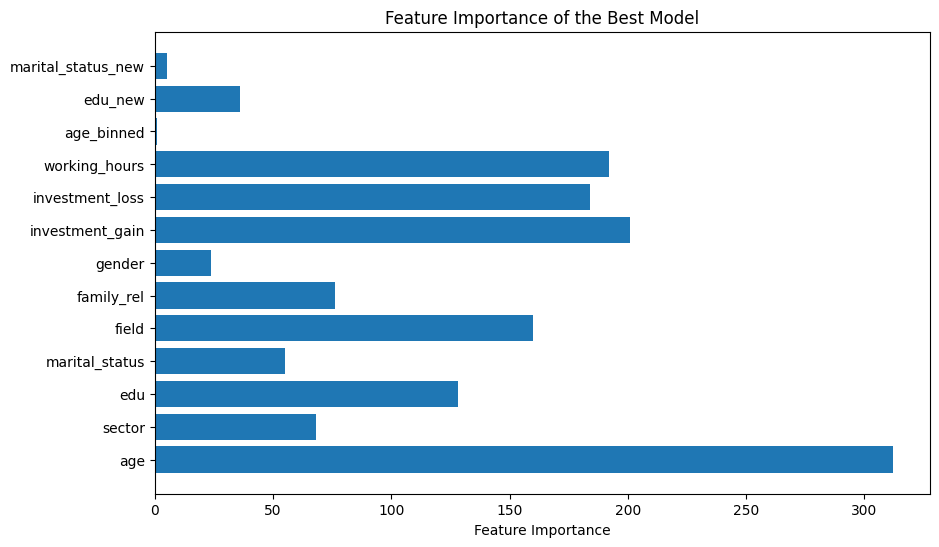

In [34]:
# Plot feature importance
importance = best_gbm.feature_importance()
feature_names = X_encoded.columns
plt.figure(figsize=(10, 6))
plt.barh(range(len(importance)), importance, tick_label=feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of the Best Model')
plt.show()